# 車牌辨識(Automatic Number Plate Recognition, ANPR)
### 程式修改自 [Car License Plate Recognition using Raspberry Pi and OpenCV](https://circuitdigest.com/microcontroller-projects/license-plate-recognition-using-raspberry-pi-and-opencv)

## 載入相關套件

In [1]:
# 載入相關套件
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

## 載入並顯示圖檔

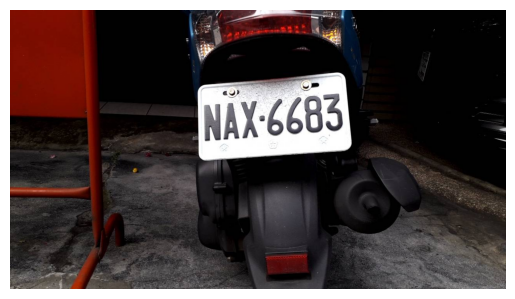

In [2]:
# 載入圖檔
image = cv2.imread('./images_ocr/1.jpg',cv2.IMREAD_COLOR)

# 顯示圖檔
image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_RGB)
plt.axis('off')
plt.show()

## 轉為灰階，萃取輪廓

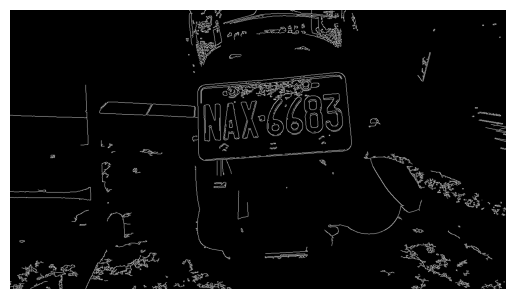

In [3]:
# 萃取輪廓
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # 轉為灰階
gray = cv2.bilateralFilter(gray, 11, 17, 17)   # 模糊化，去除雜訊
edged = cv2.Canny(gray, 30, 200)               # 萃取輪廓

# 顯示圖檔
plt.imshow(edged, cmap='gray')
plt.axis('off')
plt.show()

## 取得等高線區域，並排序，取前10個區域

In [4]:
# 取得等高線區域，並排序，取前10個區域
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]

In [5]:
cnts[0].shape

(214, 1, 2)

## 找第一個含四個點的等高線區域

In [6]:
# 找第一個含四個點的等高線區域
screenCnt = None
for i, c in enumerate(cnts):
    # 計算等高線區域周長
    peri = cv2.arcLength(c, True)
    # 轉為近似多邊形
    approx = cv2.approxPolyDP(c, 0.018 * peri, True)
    # 等高線區域維度
    print(c.shape)

    # 找第一個含四個點的多邊形
    if len(approx) == 4:
        screenCnt = approx
        print(i)
        break

(214, 1, 2)
0


## 在原圖上繪製多邊形，框住車牌

In [7]:
# 在原圖上繪製多邊形，框住車牌
if screenCnt is None:
    detected = 0
    print("No contour detected")
else:
    detected = 1
    
if detected == 1:
    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 3)
    print(f'車牌座標=\n{screenCnt}')

車牌座標=
[[[864 172]]

 [[494 195]]

 [[489 380]]

 [[870 361]]]


## 去除車牌以外的圖像，找出車牌的上下左右的座標，計算車牌寬高

In [8]:
# 去除車牌以外的圖像
mask = np.zeros(gray.shape,np.uint8)
new_image = cv2.drawContours(mask,[screenCnt],0,255,-1,)
new_image = cv2.bitwise_and(image, image, mask=mask)

# 轉為浮點數
src_pts = np.array(screenCnt, dtype=np.float32)

# 找出車牌的上下左右的座標
left = min([x[0][0] for x in src_pts])
right = max([x[0][0] for x in src_pts])
top = min([x[0][1] for x in src_pts])
bottom = max([x[0][1] for x in src_pts])

# 計算車牌寬高
width = right - left  
height = bottom - top 
print(f'寬度={width}, 高度={height}')

寬度=381.0, 高度=208.0


## 仿射(affine transformation)，將車牌轉為矩形

In [9]:
# 計算仿射(affine transformation)的目標區域座標，須與擷取的等高線區域座標順序相同
if src_pts[0][0][0] > src_pts[1][0][0] and src_pts[0][0][1] < src_pts[3][0][1]:
    print('起始點為右上角')
    dst_pts = np.array([[width, 0], [0, 0], [0, height], [width, height]], dtype=np.float32)
elif src_pts[0][0][0] < src_pts[1][0][0] and src_pts[0][0][1] > src_pts[3][0][1]:
    print('起始點為左下角')
    dst_pts = np.array([[0, height], [width, height], [width, 0], [0, 0]], dtype=np.float32)
else:
    print('起始點為左上角')
    dst_pts = np.array([[0, 0], [0, height], [width, height], [width, 0]], dtype=np.float32)
    
# 仿射
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
Cropped = cv2.warpPerspective(gray, M, (int(width), int(height)))

起始點為右上角


## 車牌號碼 OCR 辨識

In [10]:
# 車牌號碼 OCR 辨識
text = pytesseract.image_to_string(Cropped, config='--psm 11')
print("車牌號碼：",text)

車牌號碼： NAY-6683



## 顯示原圖及車牌

In [ ]:
# 顯示原圖及車牌
cv2.imshow('Orignal image',image)
cv2.imshow('Cropped image',Cropped)

# 車牌存檔
cv2.imwrite('Cropped.jpg', Cropped)

# 按 Enter 鍵結束
cv2.waitKey(0)

# 關閉所有視窗
cv2.destroyAllWindows()